## Setup

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s4e10/.DS_Store
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

## Data exploration

In [3]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
train.tail()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0
58644,58644,31,75000,MORTGAGE,2.0,VENTURE,B,15000,11.11,0.20,N,5,0


In [5]:
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [7]:
numerical_features = list(train.select_dtypes(include=['float64', 'int']).columns)
categorical_features = list(train.select_dtypes(include=['object']).columns)
print(f'{len(numerical_features)} numerical features: ',numerical_features)
print(f'{len(categorical_features)} categorical features: ',categorical_features)

9 numerical features:  ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']
4 categorical features:  ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


### Check class imbalance

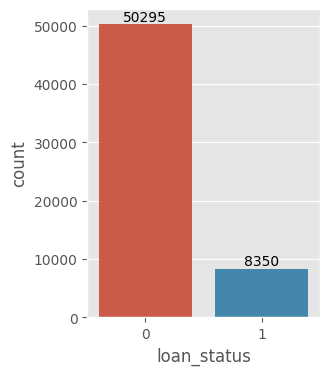

In [8]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='loan_status',data=train)
for i in ax.containers:
    ax.bar_label(i,)

In [9]:
neg, pos = np.bincount(train['loan_status'])
total = neg + pos
print('Traning data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Traning data:
    Total: 58645
    Positive: 8350 (14.24% of total)



### Feature distribution

#### Numerical features

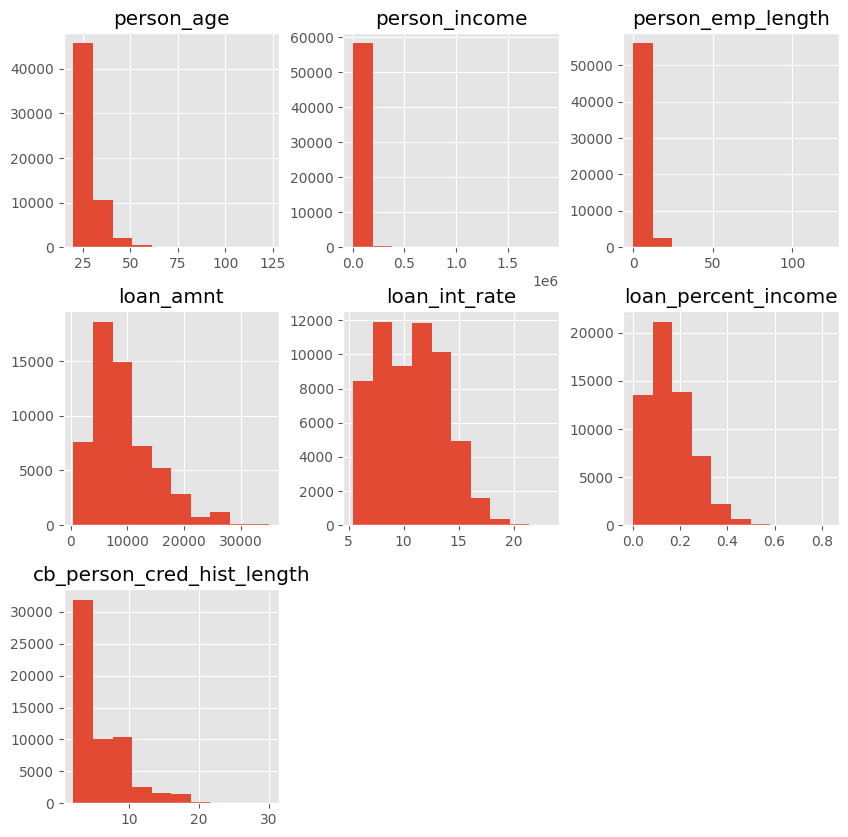

In [10]:
p = train.drop(['id','loan_status'],axis=1).hist(figsize=(10,10))

The plots show that the numerical features are right skewed. A technique is to use log-transformed data instead.

In [11]:
def boxplot_by_label(df, selected_columns, log_trans=False):
    '''Boxplot for features.
       df: data frame
       selected_columns: selected columns for the box plot
    '''
    if log_trans:
        df_log = df[selected_columns].apply(np.log1p)
    else:
        df_log = df
    
    df_log['loan_status'] = df['loan_status']
    fig, axes = plt.subplots(1, len(selected_columns), figsize=(len(selected_columns) * 6, 6))
    
    for i, col in enumerate(selected_columns):
        sns.boxplot(x='loan_status', y=col, data=df_log, ax=axes[i])
        axes[i].set_title(f'Box Plot of {col} by Label')
    
    plt.tight_layout()
    plt.show()

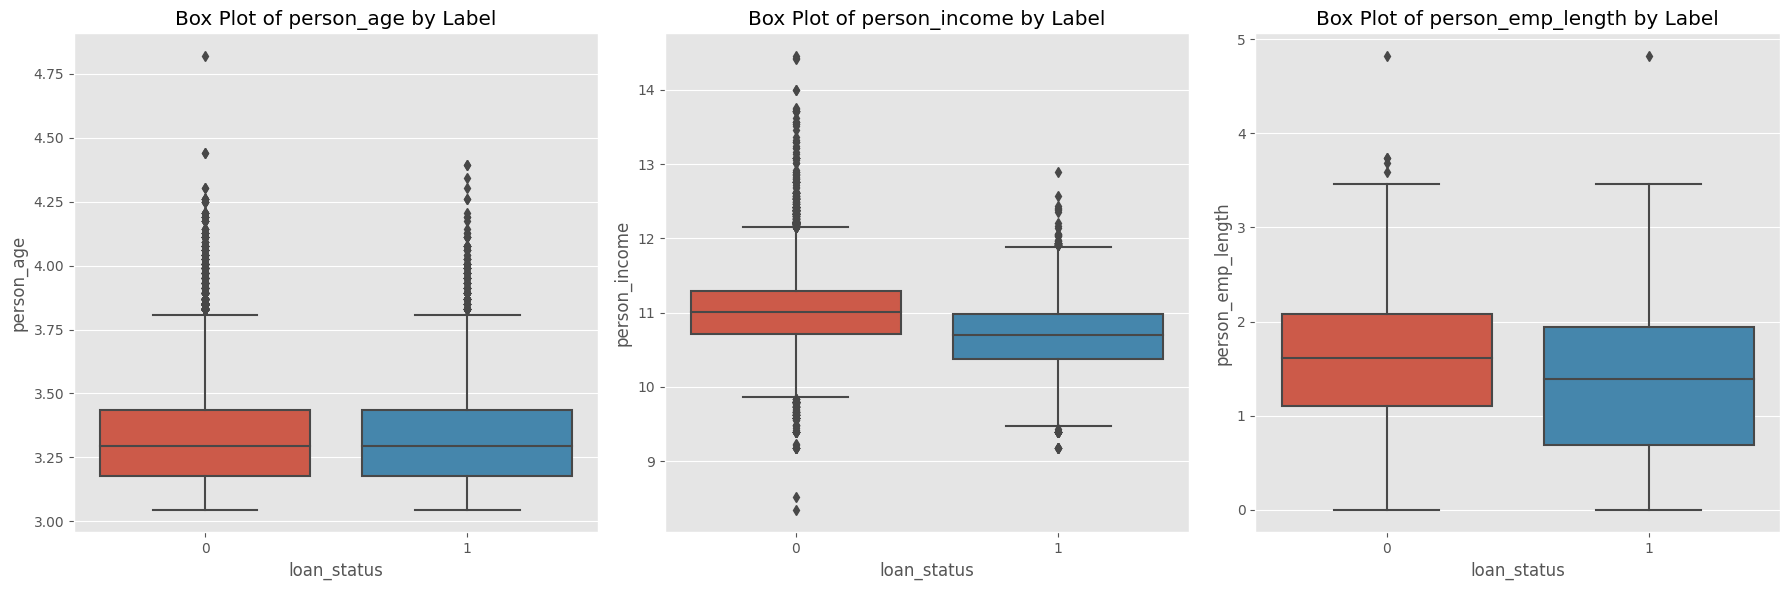

In [12]:
selected_columns = ['person_age', 'person_income', 'person_emp_length']
boxplot_by_label(train,selected_columns, log_trans=True)

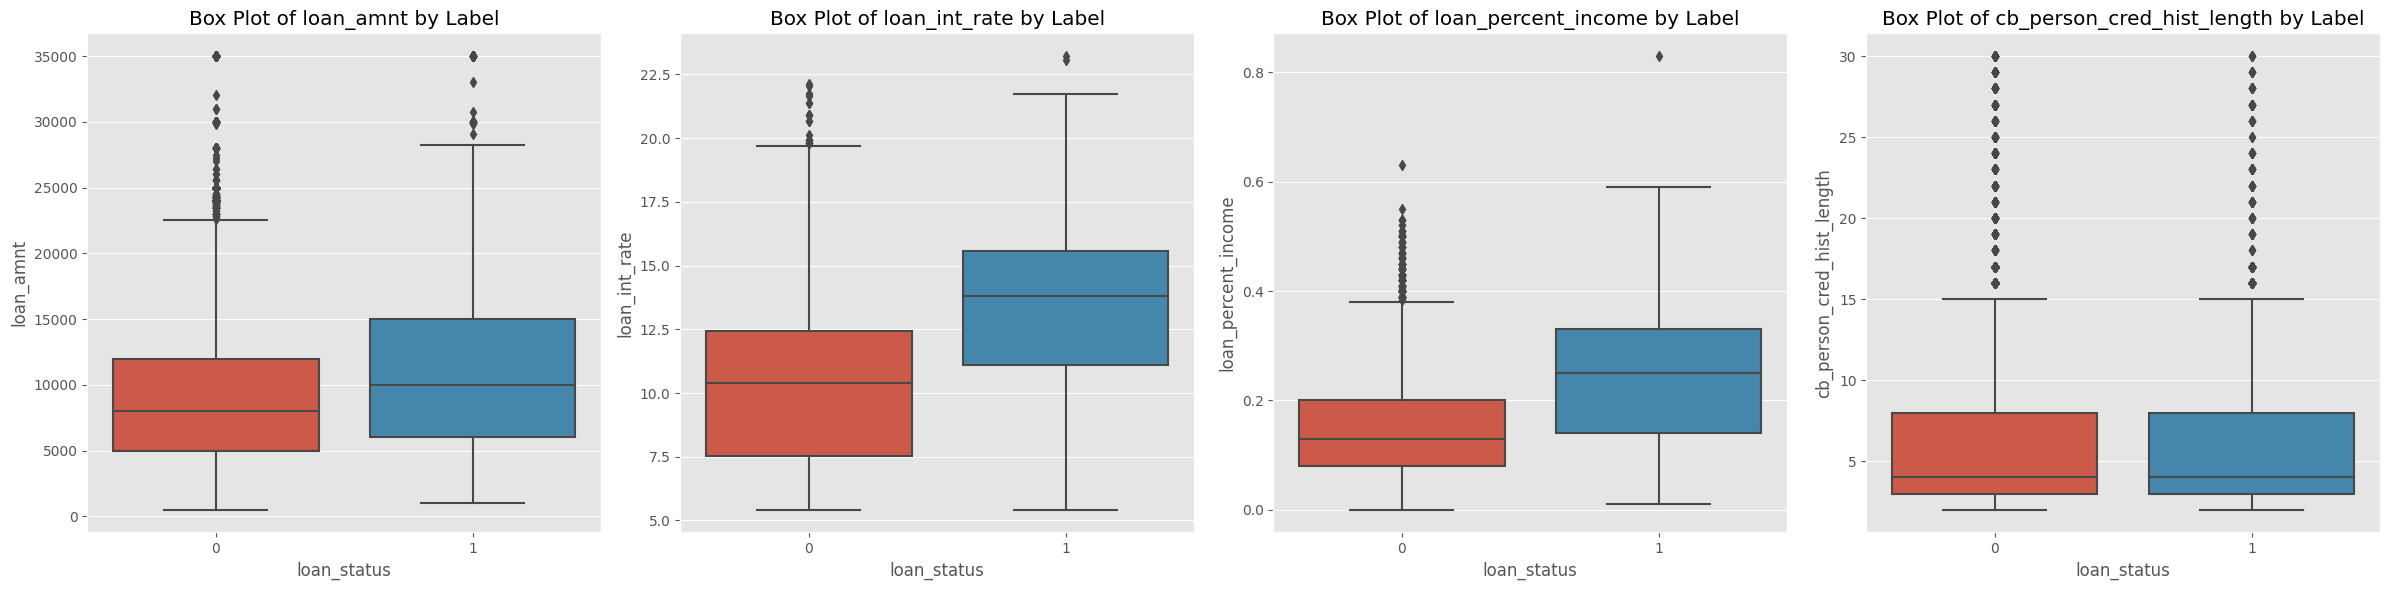

In [13]:
selected_columns = ['loan_amnt','loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
boxplot_by_label(train,selected_columns)

The boxplots reveal that the distributions of 'person_income,' 'person_emp_length,' 'loan_amnt,' 'loan_int_rate,' and 'loan_percent_income' differ notably between approved and non-approved loans. However, differences in 'person_age' and 'cb_person_cred_hist_length' are less pronounced.

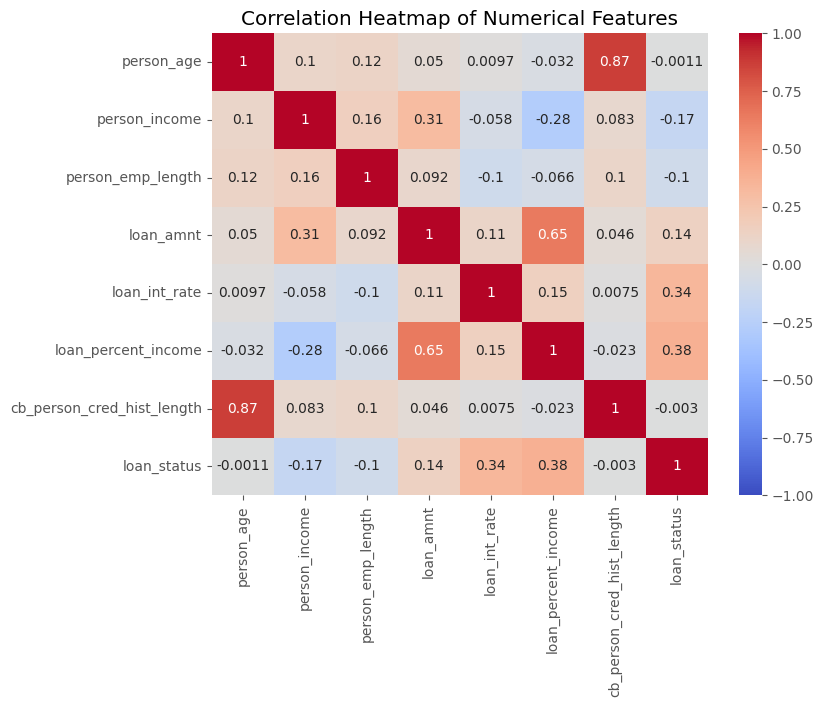

In [14]:
num_cols = train.select_dtypes(include=['float64', 'int']).columns.drop('id')
plt.figure(figsize=(8, 6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

- cb_person_cred_hist_length and person_age show a strong correlation = 0.87
- load_percent_income and loan_amount show a relatively large correlation = 0.65
- correlation of the rest numerical features is relatively small


#### Categorical features

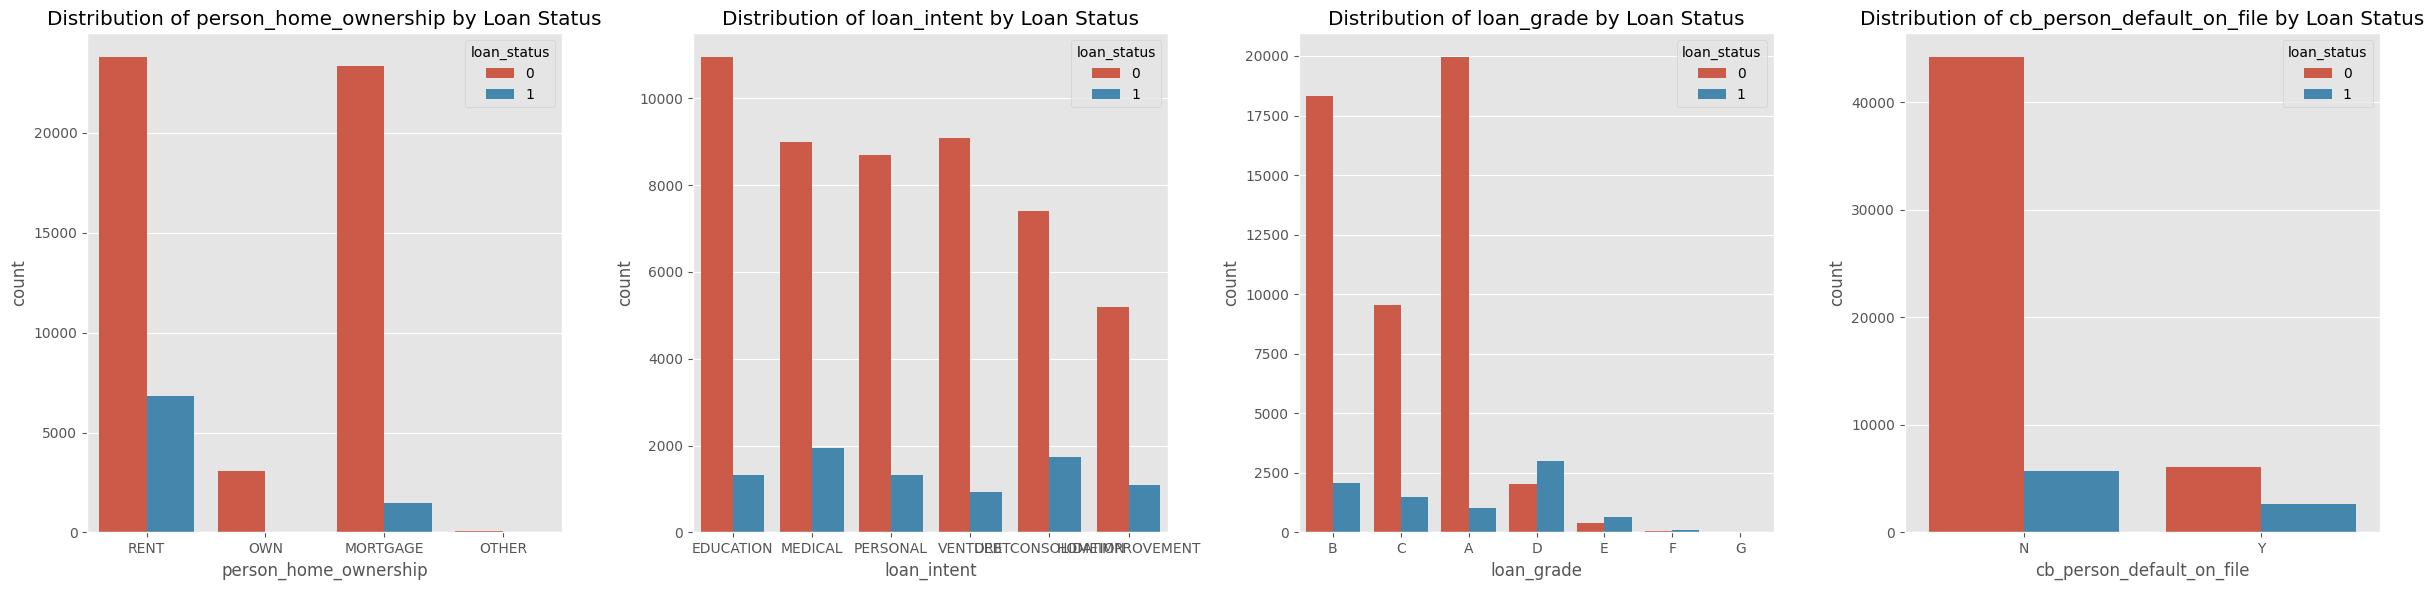

In [15]:
cat_cols = train.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(1, len(selected_columns), figsize=(len(selected_columns) * 6, 6))
for i,col in enumerate(cat_cols):
    sns.countplot(data=train, x=col, hue='loan_status',ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Loan Status')
plt.tight_layout()
plt.show()

- person_home_ownership = 'RENT' and 'MORTAGE' have more approved loans than 'OWN' and 'OTHER'. 
- load_grade = 'D' and 'F' have notable higher rate of approved loans than other categories.

## Model traning

In [16]:
X = train.drop(columns=['id','loan_status'],axis=1)
y = train['loan_status']

In [17]:
numerical_features = X.select_dtypes(include=['float64', 'int']).columns
categorical_features = X.select_dtypes(include=['object']).columns

Pipelines in the modeling step offers several advantages:

- Streamlines Workflow: Pipelines allow you to sequentially apply data preprocessing, transformation, and modeling steps, making the workflow more organized and efficient.

- Reduces Data Leakage: By combining preprocessing and modeling steps in a single pipeline, pipelines prevent data leakage by ensuring transformations are only fitted on the training data, not on the validation or test data.

- Enhances Code Readability and Reusability: Pipelines make the code cleaner and easier to understand, allowing you to reuse the same pipeline on different datasets with minimal adjustments.


In [18]:
# Define transfomer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputation for numerical if needed
    ('scaler', StandardScaler())  # Standard scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categories if needed
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42))
])

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)

In [20]:
param_grid = {
    'classifier__n_estimators': [500, 1000],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [5],
    'classifier__max_features': ['sqrt']
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [21]:
# Fit model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                                        ('cat',...
                                                                         Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_split': [5],
                         'classifier__n_estimators': [500, 1000]},
             scoring='accuracy', verbose=2)

### Model evaluation

In [22]:
# Print best parameters and best score from grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluate performance
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 1000}
Best Cross-Validation Score: 0.9480474345658939
Test Set Accuracy: 0.9486017733606158
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     35207
           1       0.91      0.71      0.80      5845

    accuracy                           0.95     41052
   macro avg       0.93      0.85      0.88     41052
weighted avg       0.95      0.95      0.95     41052



For load approval, recall is typically more important than precision if the goal is to minimize the chances of incorrectly rejecting applicants who should have been approved: 

- Recall (Sensitivity): Measures the proportion of actual approved applicants that the model correctly identifies. Higher recall means fewer false negatives, reducing the risk of missing out on eligible applicants who qualify for a loan but are incorrectly rejected by the model.

- Precision: Measures the proportion of predicted approvals that are actually correct. Higher precision indicates fewer false positives, meaning that when the model approves a loan, it is likely to be correct.

The current model has Recall=0.7 and precision is 0.9. The recall needs to be further improved.

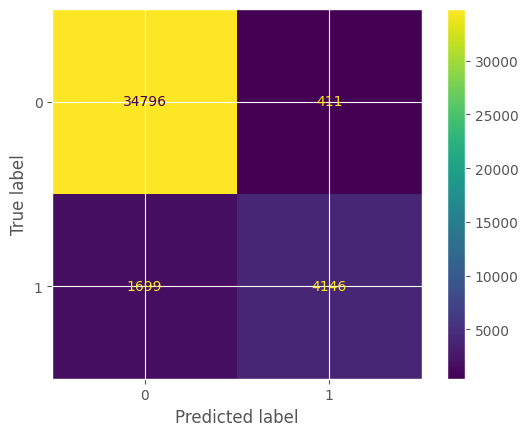

In [23]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = [0, 1]).plot()
plt.show()

In [24]:
#Refit the model with the best parameters
best_rf_params = {
    'n_estimators': 1000,
    'max_depth': 20,
    'min_samples_split': 5,
    'max_features': 'sqrt'
}

In [25]:
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_rf_params, random_state=42))
])

# Refit the model on the full training data
best_model_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=5,
                                        n_estimators=1000, random_state=42))])

### Feature Importance

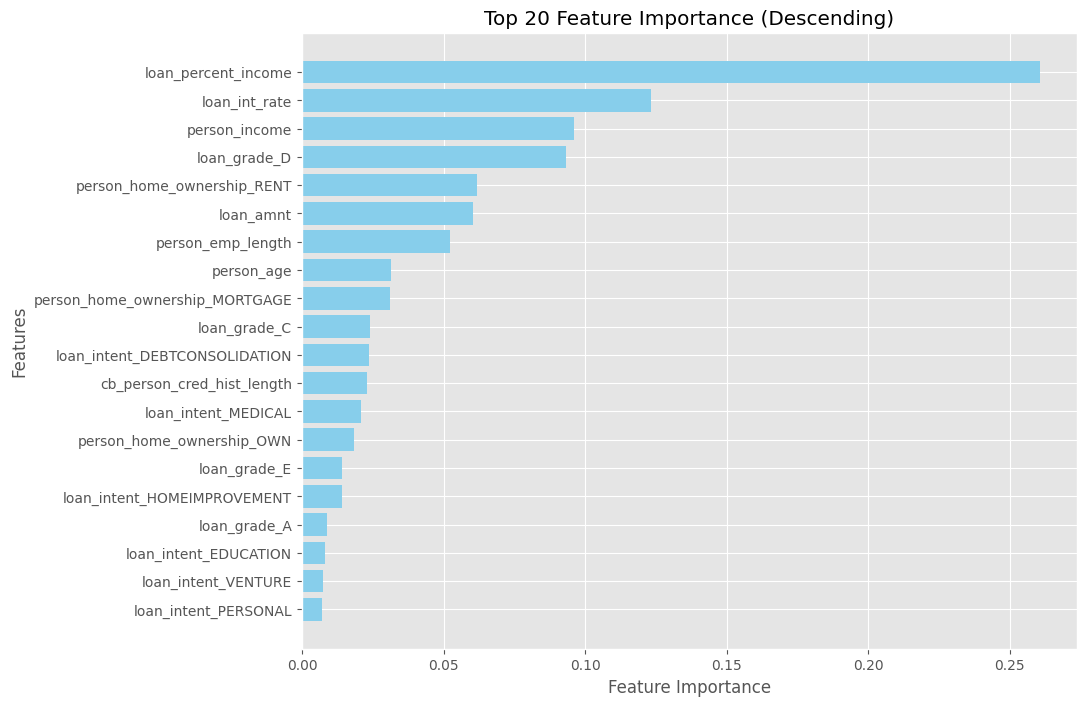

In [26]:
importances = best_model_pipeline.named_steps['classifier'].feature_importances_
# Extract feature names after preprocessing
feature_names = best_model_pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out(numerical_features).tolist()
feature_names += best_model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).tolist()

# Sort feature importances in descending order and display top 20
sorted_indices = np.argsort(importances)[::-1][:20]
top_feature_names = [feature_names[i] for i in sorted_indices]
top_importances = importances[sorted_indices]

# Plot the top 20 features in descending order
plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importance (Descending)")
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

The top 5 most important features in the model are 'loan_percent_income', 'loan_int_rate', and 'person_income'. These features had the highest impact on the model's predictions, indicating that factors related to the applicant's income, the loan amount, and interest rate are critical in determining loan approval likelihood. This result aligns well with the insights we uncovered during the EDA phase, where these variables showed strong associations with loan approval outcomes.

### Prediction

In [27]:
y_pred = best_model_pipeline.predict_proba(test)
test['loan_status'] = y_pred[:,1]

## Submission

In [28]:
submission = test[['id','loan_status']]

In [29]:
submission

,id,load_status
0,58645,0.918869
1,58646,0.010695
2,58647,0.698649
3,58648,0.033766
4,58649,0.212233
...,...,...
39093,97738,0.020565
39094,97739,0.001573
39095,97740,0.024938
39096,97741,0.399554


In [30]:
submission.to_csv('/kaggle/output/submission.csv', index=False)